# Libraries

In [26]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

from stats import  full_bootstrap_mean_diff, standardize_data, bootstrap_mean_difference

# strategies

Перед тем, как сравнивать частоту употребления стратегий в группах, стоит убедиться, что нету для каждой из стратегий зависимости между тем, сколько человек сказал слов


In [2]:
strats = pd.read_csv('humans.tsv', sep='\t')
strats.head(4)

,ID,fonetics,derivation,lexico-semantic field,other,strat_sum,type
0,pr_A_1,10.0,5.0,13.0,16,44.0,senior academics
1,pr_B_1,10.0,3.0,16.0,22,51.0,senior academics
2,pr_E_1,5.0,1.0,10.0,36,52.0,senior academics
3,pr_G_1,14.0,1.0,7.0,33,55.0,senior academics


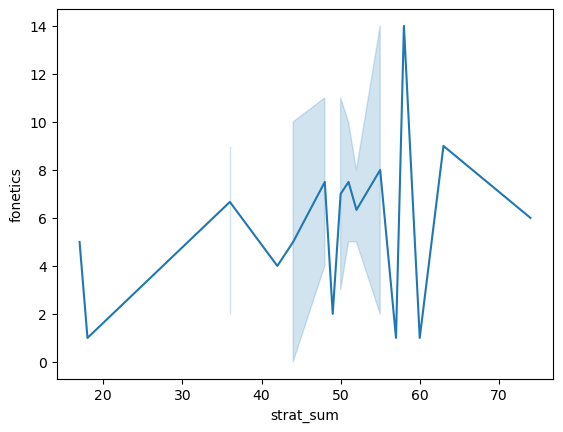

In [3]:
sns.lineplot(strats[strats['type']=='senior academics'], x='strat_sum', y='fonetics');

<Axes: xlabel='fonetics', ylabel='Count'>

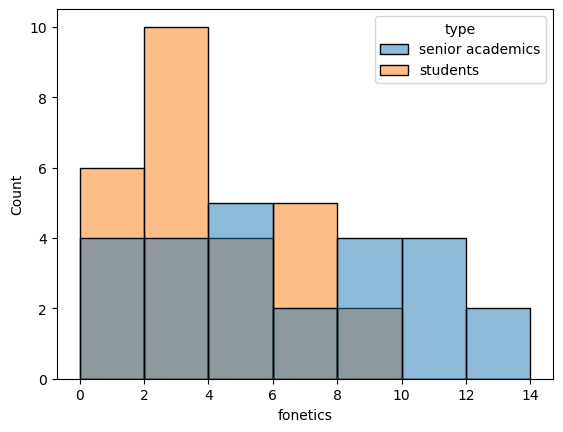

In [4]:
# sns.lineplot(strats[strats['type']=='senior academics'], x='strat_sum', y='fonetics');
sns.histplot(strats, x='fonetics',hue='type')

## количество сказанных слов

In [5]:
res = stats.normaltest(strats[strats['type']!='senior academics']['strat_sum'])
res

NormaltestResult(statistic=7.971465675012011, pvalue=0.01857882407353406)

Наблюдаемая разница средних (стандартизированная): -0.2703303465662201
p-значение: 0.549
Доверительный интервал (95%): [-0.7794683   0.32010648]


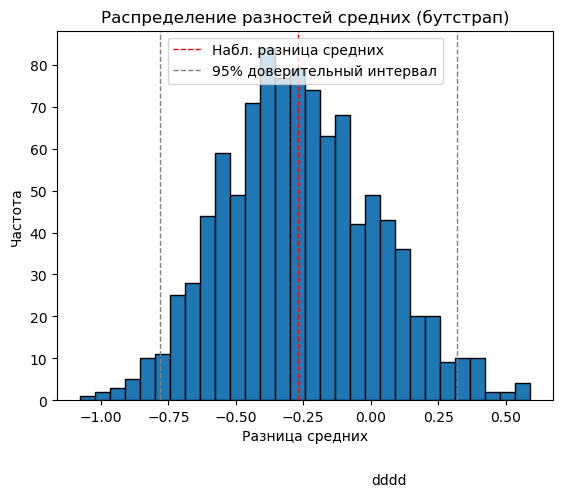

Разница средних при t-тесте (стандартизированная): -0.2703303465662201
p-значение при t-тесте: 0.3350066096207589


In [44]:
# 1. Стандартизация данных
def standardize_data(df, column):
    mean = df[column].mean()
    std = df[column].std()
    df[column + '_standardized'] = (df[column] - mean) / std
    return df

strats = standardize_data(strats, 'strat_sum')


# 2. Бутстрап для сравнения стандартизированных средних
def bootstrap_mean_difference(group1, group2, num_iterations=1000):
    mean_diffs = []
    n1 = len(group1)
    n2 = len(group2)

    for _ in range(num_iterations):
        # Сэмплирование с возвращением
        sample1 = np.random.choice(group1, size=n1, replace=True)
        sample2 = np.random.choice(group2, size=n2, replace=True)
        mean_diff = np.mean(sample1) - np.mean(sample2)
        mean_diffs.append(mean_diff)

    return np.array(mean_diffs)

# Выбираем стандартизированные данные
group1 = strats[strats['type'] != 'senior academics']['strat_sum_standardized'].values
group2 = strats[strats['type'] == 'senior academics']['strat_sum_standardized'].values


mean_diffs_bootstrap = bootstrap_mean_difference(group1, group2)

# Вычисляем p-value и доверительный интервал
observed_diff = np.mean(group1) - np.mean(group2)
p_value = np.mean(np.abs(mean_diffs_bootstrap) >= np.abs(observed_diff))
ci = np.percentile(mean_diffs_bootstrap, [2.5, 97.5])


# Вывод результатов
print("Наблюдаемая разница средних (стандартизированная):", observed_diff)
print("p-значение:", p_value)
print("Доверительный интервал (95%):", ci)

# Строим гистограмму распределения разностей средних
plt.hist(mean_diffs_bootstrap, bins=30, edgecolor='black')
plt.axvline(observed_diff, color='red', linestyle='dashed', linewidth=1, label=f'Набл. разница средних')
plt.axvline(ci[0], color='grey', linestyle='dashed', linewidth=1, label=f'95% доверительный интервал')
plt.axvline(ci[1], color='grey', linestyle='dashed', linewidth=1)
plt.title('Распределение разностей средних (бутстрап)')
plt.xlabel('Разница средних')
plt.ylabel('Частота')
plt.text(0, -20, 'dddd', fontsize=10)
plt.legend()
plt.show()


# Сравнение с t-тестом (для сравнения) - выводим только p-value и разницу средних
t_stat, p_value_ttest = stats.ttest_ind(group1, group2)
print("Разница средних при t-тесте (стандартизированная):", np.mean(group1) - np.mean(group2))
print("p-значение при t-тесте:", p_value_ttest)


между группами академиков и студентов принята гипотеза об отсутствии разницы между средними количества сказанных слов

In [21]:
stats.ttest_ind(strats[strats['type']!='senior academics']['strat_sum'], strats[strats['type']=='senior academics']['strat_sum'])

TtestResult(statistic=-0.9734686470663446, pvalue=0.33500660962075846, df=50.0)

## доказать независимость частот с определенной стратегией от количества сказанных слов

### доказать независимость частот со стратегией "фонетика" от количества сказанных слов

In [18]:
x=strats['fonetics']/strats['strat_sum']
y=strats['strat_sum']
def statistic(x): # permute only `x`
    return stats.pearsonr(x, y).statistic
res_exact = stats.permutation_test((x,), statistic,
    permutation_type='pairings')
res_asymptotic = stats.pearsonr(x, y)
print(res_exact.pvalue, res_asymptotic.pvalue) # asymptotic pvalue is too low
print(res_exact)

0.929 0.9065481618184839
PermutationTestResult(statistic=-0.016684009954635075, pvalue=0.929, null_distribution=array([-0.26909941, -0.11755229, -0.10984525, ..., -0.02418559,
        0.34356897,  0.02124125]))


In [19]:
x=strats['fonetics']/strats['strat_sum']
y=strats['strat_sum']
def statistic(x): # permute only `x`
    return stats.spearmanr(x, y).statistic
res_exact = stats.permutation_test((x,), statistic,
    permutation_type='pairings')
res_asymptotic = stats.spearmanr(x, y)
res_exact.pvalue, res_asymptotic.pvalue # asymptotic pvalue is too low

(0.3238, 0.32922028386214164)

In [20]:
res_exact

PermutationTestResult(statistic=0.1380092381063527, pvalue=0.3238, null_distribution=array([ 0.10567736,  0.0672084 , -0.01494708, ..., -0.09785099,
        0.06241849, -0.26335943]))

In [21]:
x=strats['fonetics']/strats['strat_sum']
y=strats['strat_sum']
def statistic(x): # permute only `x`
    return stats.kendalltau(x, y).statistic
res_exact = stats.permutation_test((x,), statistic,
    permutation_type='pairings')
res_asymptotic = stats.kendalltau(x, y)
res_exact.pvalue, res_asymptotic.pvalue # asymptotic pvalue is too low

(0.378, 0.37141203727581673)

In [22]:
res_exact

PermutationTestResult(statistic=0.08712786184136909, pvalue=0.378, null_distribution=array([ 0.10640394,  0.0107946 , -0.12028271, ...,  0.05628614,
       -0.07864639, -0.24981794]))

не отвергаем нулевую гипотезу, частота сказанных слов со стратегией фонетика не коррелирует со общим количеством сказанных слов

Более того, в этой связи есть линейность?

(0.0, 15.0)

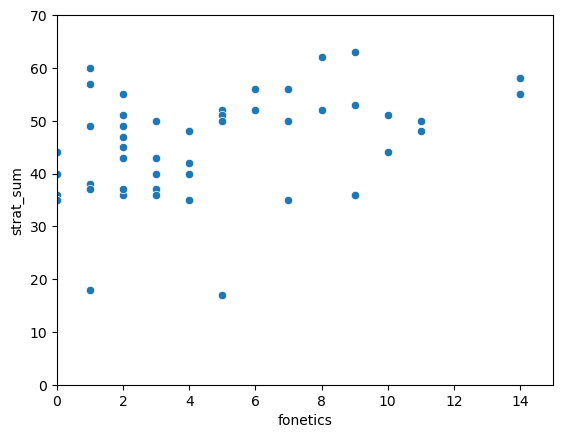

In [16]:
sns.scatterplot(strats, y='strat_sum', x='fonetics');
plt.ylim(0,70)
plt.xlim(0,15)

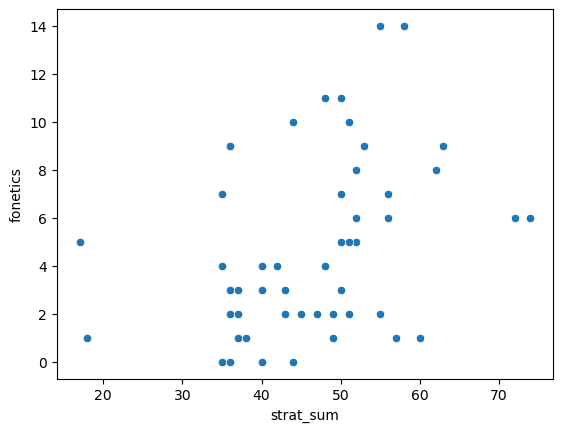

In [25]:
sns.scatterplot(strats, y='fonetics', x='strat_sum');
# plt.ylim(0,70)
# plt.xlim(0,15)

поэтому не стоит сравнивать количества сказанных слов со стратегией фонетика напрямую, их надо нормализовывать по количеству сказанных слов

или стоит?? стоит, потому что на графике не видно связи, точки разбросаны

### доказать независимость частот со стратегией "лексика" от количества сказанных слов

In [46]:
strats.columns

Index(['ID', 'fonetics', 'derivation', 'lexico-semantic field', 'other',
       'strat_sum', 'type', 'strat_sum_standardized'],
      dtype='object')

# сравнение количества слов по категориям

In [27]:
strats.head(1)

,ID,fonetics,derivation,lexico-semantic field,other,strat_sum,type,strat_sum_standardized
0,pr_A_1,10.0,5.0,13.0,16,44.0,senior academics,-0.218


Observed mean difference (standardized): -0.2703303465662201
bootstrap p-value: 0.344
Confidence interval (95%): [-0.56604479  0.54588514]


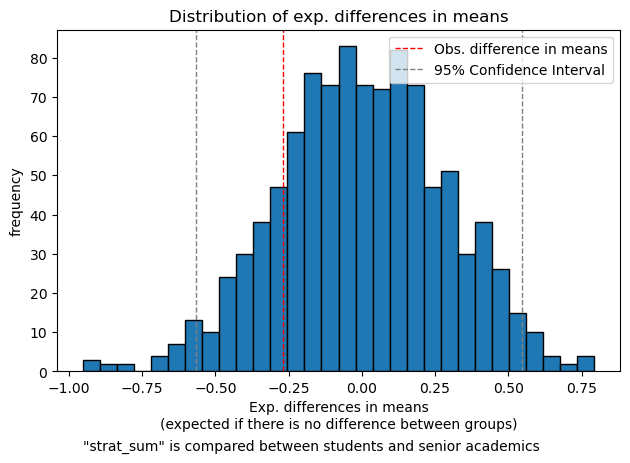

In [74]:
full_bootstrap_mean_diff(strats, 'strat_sum')

принимаем нулевую гипотезу об отсутствии различий в среднем количестве сказанных слов

Observed mean difference (standardized): -0.7115128827610983
bootstrap p-value: 0.008
Confidence interval (95%): [-0.51705365  0.50803805]


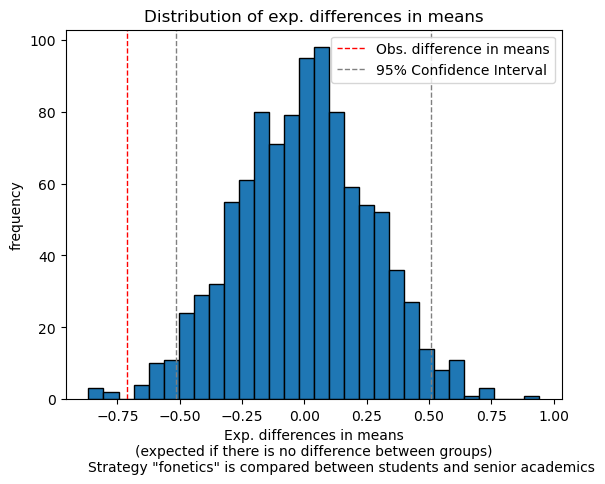

In [52]:
full_bootstrap_mean_diff(strats, 'fonetics')

Observed mean difference (standardized): -0.8524593955322957
bootstrap p-value: 0.001
Confidence interval (95%): [-0.53543178  0.52891651]


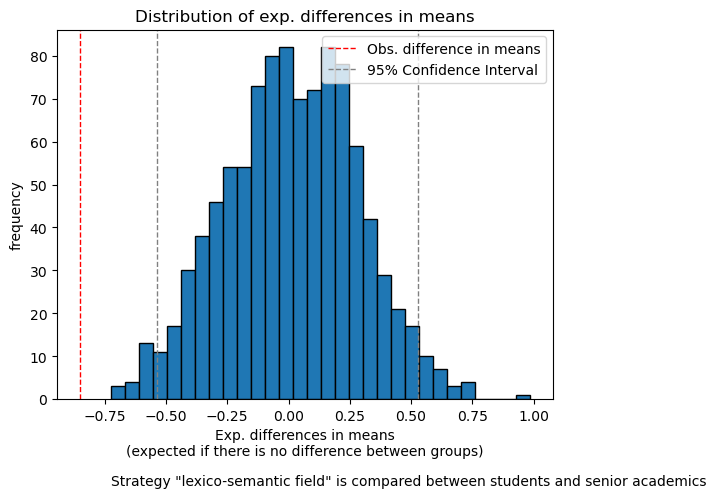

In [54]:
full_bootstrap_mean_diff(strats, 'lexico-semantic field')

Observed mean difference (standardized): 0.4767813829282193
bootstrap p-value: 0.083
Confidence interval (95%): [-0.53694083  0.51779527]


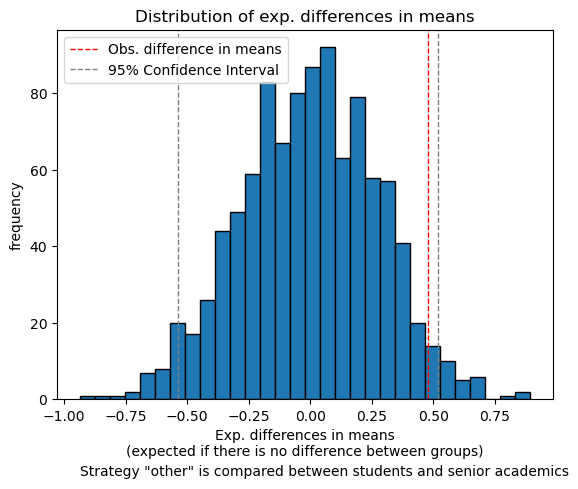

In [55]:
full_bootstrap_mean_diff(strats, 'other')

Observed mean difference (standardized): -0.0318556238103649
bootstrap p-value: 0.895
Confidence interval (95%): [-0.50709623  0.50482396]


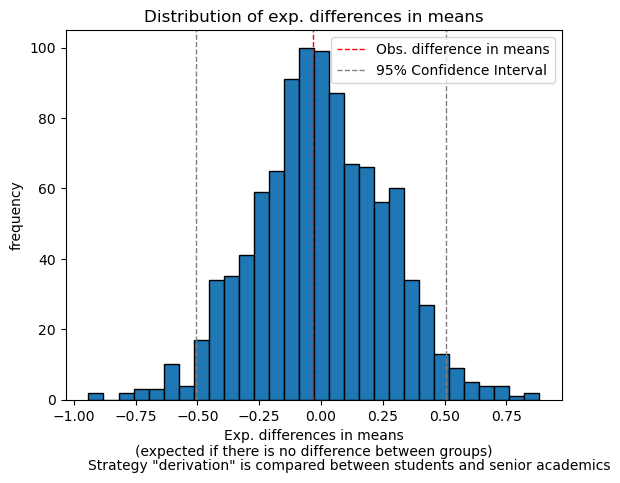

In [53]:
full_bootstrap_mean_diff(strats, 'derivation')

# Words

In [58]:
words = pd.read_csv('words.tsv', sep='\t')

df = words.fillna('0')
df['Стратегия'] = df['Стратегия'].str[0]
def renamestrats(row):
    '''
    df['fonetics'] = df['1'] 
    df['derivation'] = df['2']
    df['lexico-semantic field'] = df['3'] + df['4'] + df['5'] + df['6'] + df['7']
    df['other'] = df['8']

    '''
    
    
    stratsfict = {'1':'fonetics', '2': 'derivation', 
                  '8':'other', **dict.fromkeys(['n', '0'], 'None')
                  }
    stratsfict.update(dict.fromkeys(['3', '4', '5', '6', '7'], 'lexico-semantic field'))
    #print(stratsfict[row['Стратегия']])
    row['strategies']=stratsfict[row['Стратегия']]
    return row

df = df.apply(renamestrats, axis=1)
df['Частотность'] = df['Частотность'].astype('float', errors = 'ignore')
df['Пауза'] = df['Пауза'].astype('float', errors='ignore' )
df.head()

,Unnamed: 0,ID,квота сек,Слово,Предыдущее + слово,Первая_буква,Стратегия,Порядок_буква,Порядок_весь_тест,Частотность,Пауза,VP,VS,N of words,N of words_P,N of words_O,N of words_S,Mean pause,type,strategies
0,0,Б_В_10,1,пара,0,п,0,1.0,1,"152,7",0,0,0,59,28,13,18,"2,390357143",students,None
1,1,Б_В_10,1,период,пара период,п,8,2.0,2,"204,2","0,1",0,0,59,28,13,18,"2,390357143",students,other
2,2,Б_В_10,1,парад,период парад,п,1,3.0,3,"13,2","3,15",1.0,0,59,28,13,18,"2,390357143",students,fonetics
3,3,Б_В_10,1,предлог,парад предлог,п,8,4.0,4,"12,7",1,1.0,0,59,28,13,18,"2,390357143",students,other
4,4,Б_В_10,1,по,предлог по,п,3,5.0,5,"5786,7","0,7",0,0,59,28,13,18,"2,390357143",students,lexico-semantic field


In [64]:
# dfj[dfj['strategies']=='other'][['type','Частотность']]

,type,Частотность
1,students,"204,2"
3,students,"12,7"
5,students,"18,5"
6,students,"16,3"
8,students,"2,1"
...,...,...
2562,senior academics,0
2563,senior academics,"3,3"
2564,senior academics,2
2565,senior academics,"5,5"


In [84]:
df['Частотность'] = pd.to_numeric(df['Частотность'].str.replace(',','.'))

In [86]:
cols = df.select_dtypes('number').columns  # limits to a (float), b (int) and e (timedelta)
df_sub = df.loc[:, 'Частотность']


# OPTION 1: z-score filter: z-score < 3
#lim = np.abs((df_sub - df_sub.mean()) / df_sub.std(ddof=0)) < 3

# OPTION 2: quantile filter: discard 1% upper / lower values
#lim = np.logical_and(df_sub < df_sub.quantile(0.99, numeric_only=False),
#                     df_sub > df_sub.quantile(0.01, numeric_only=False))

# OPTION 3: iqr filter: within 2.22 IQR (equiv. to z-score < 3)
iqr = df_sub.quantile(0.75) - df_sub.quantile(0.25)
lim = np.abs((df_sub - df_sub.median()) / iqr) < 2.22


# replace outliers with nan
df.loc[:, 'Частотность'] = df_sub.where(lim, np.nan)
df = df.reset_index() #важная часть кода
df["Частотность"] = df["Частотность"].fillna(220)
dfj = df[df['strategies'] !='None']

dfj['Word frequency'] = (dfj['Частотность'])

/tmp/ipykernel_1528/2370109429.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfj['Word frequency'] = (dfj['Частотность'])


In [87]:
dfj['strategies'].unique()

array(['other', 'fonetics', 'lexico-semantic field', 'derivation'],
      dtype=object)

other
Observed mean difference (standardized): 0.13023920842930364
bootstrap p-value: 0.014
Confidence interval (95%): [-0.09580061  0.10521891]


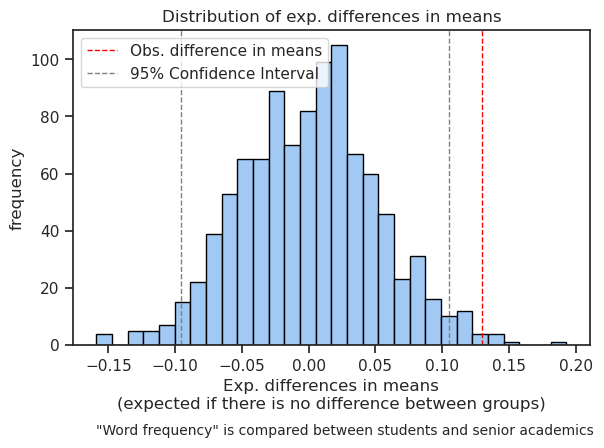



fonetics
Observed mean difference (standardized): 0.058784918827033183
bootstrap p-value: 0.637
Confidence interval (95%): [-0.23531538  0.24411093]


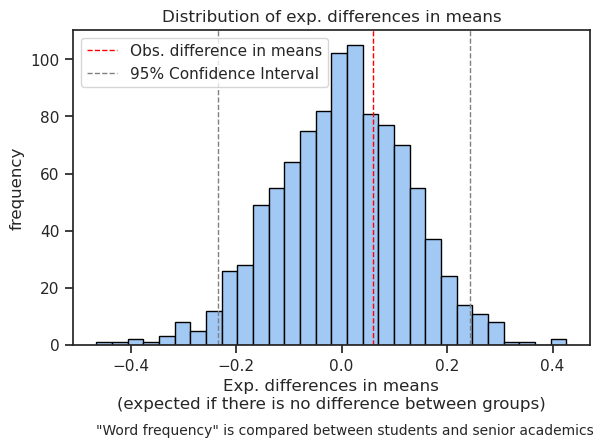



lexico-semantic field
Observed mean difference (standardized): 0.15903940245903722
bootstrap p-value: 0.092
Confidence interval (95%): [-0.18430685  0.18675747]


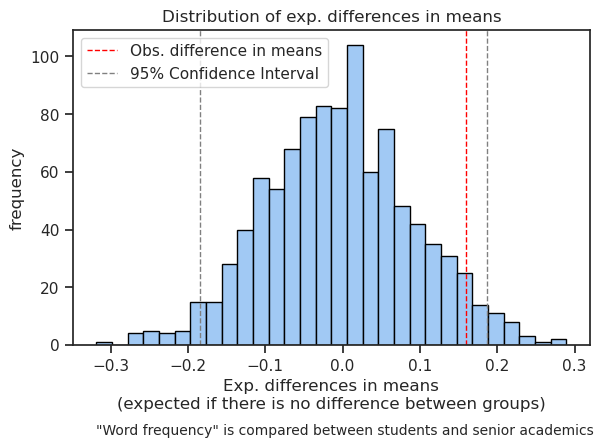



derivation
Observed mean difference (standardized): 0.26884649136897343
bootstrap p-value: 0.065
Confidence interval (95%): [-0.28422874  0.27107747]


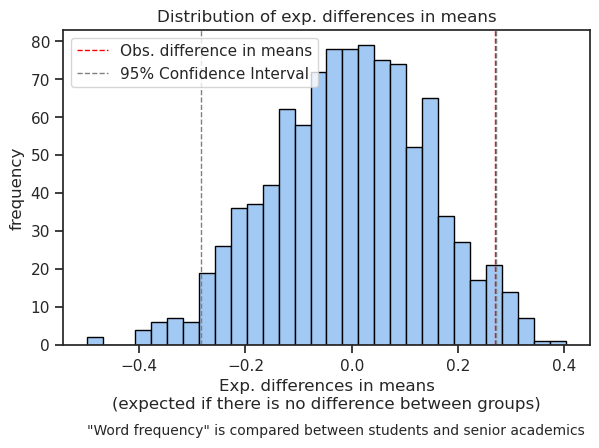

In [ ]:
for i in dfj['strategies'].unique():
    print(i)
    full_bootstrap_mean_diff(dfj[dfj['strategies']==i][['type','Word frequency']], 'Word frequency', i)
    print('\n')

(-10.0, 280.0)

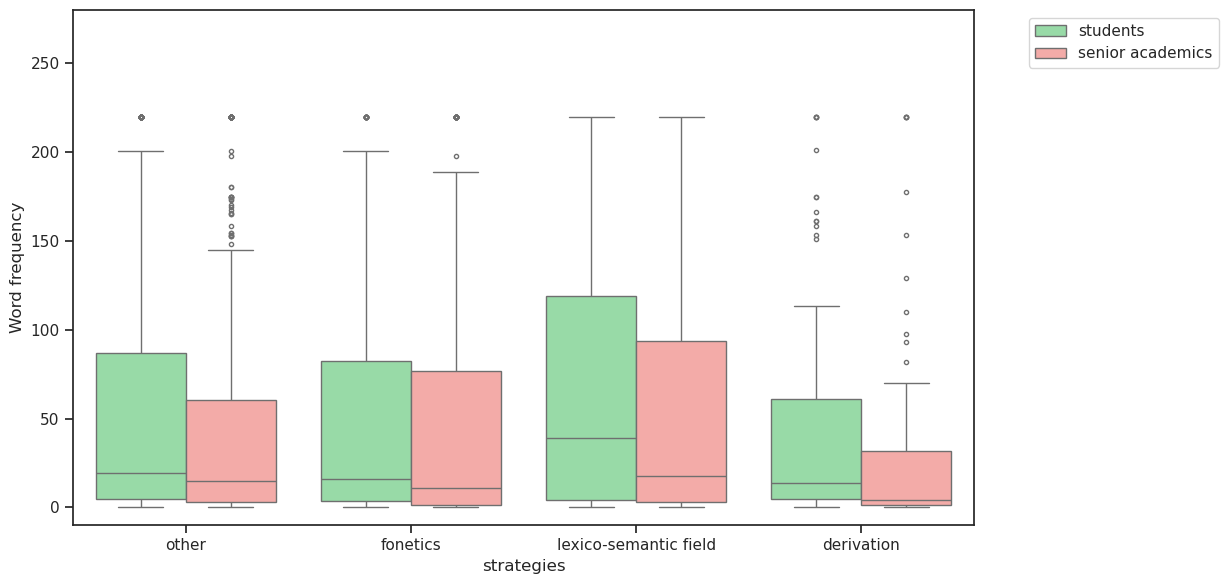

In [93]:
plt.figure(figsize=(10, 6))
sns.set_theme(style="ticks", palette="pastel")
g = sns.boxplot(data = dfj, x='strategies',y='Word frequency', hue='type', palette={'senior academics':'r', 'students':'g'}, fliersize=3);
plt.tight_layout()
g.legend( bbox_to_anchor=(1.28, 1))
plt.ylim((-10,280))

In [ ]:
U1, p1 = mannwhitneyu(*dfj[dfj['strategies']=='other'].groupby('type')['Частотность'].apply(list))
U2, p2 = mannwhitneyu(*dfj[dfj['strategies']=='fonetics'].groupby('type')['Частотность'].apply(list))
U3, p3 = mannwhitneyu(*dfj[dfj['strategies']=='lexico-semantic field'].groupby('type')['Частотность'].apply(list))

U4, p4 = mannwhitneyu(*dfj[dfj['strategies']=='derivation'].groupby('type')['Частотность'].apply(list))

In [ ]:
plt.figure(figsize=(10, 6))
sns.set_theme(style="ticks", palette="pastel")
g = sns.boxplot(data = dfj, x='strategies',y='Частотность', hue='type', palette={'senior academics':'r', 'students':'g'}, fliersize=3);
plt.xlabel('Strategy')
plt.ylabel('Word frequency')
plt.title(f'Word frequency by strategy in groups')
g.legend( bbox_to_anchor=(1.28, 1))
plt.ylim((-10,280))

plt.text(-0.3, 257.5, f"U = {U1:.1f}", rotation = 0, fontsize = 11, bbox = dict(facecolor = 'orange', alpha = 0.3))         # Size
      # Style)
plt.text(-0.3, 240, f"pval = {p1:.3f}", rotation = 0, fontsize = 11, bbox = dict(facecolor = 'orange', alpha = 0.3))         # Size
      # Style)
plt.text(0.7, 257.5, f"U = {U2:.1f}", rotation = 0, fontsize = 11, bbox = dict(facecolor = 'orange', alpha = 0.3))         # Size
      # Style)
plt.text(0.7, 240, f"pval = {p2:.3f}", rotation = 0, fontsize = 11, bbox = dict(facecolor = 'orange', alpha = 0.3))         # Size
      # Style)
plt.text(1.7, 257.5, f"U = {U3:.1f}", rotation = 0, fontsize = 11, bbox = dict(facecolor = 'orange', alpha = 0.3))         # Size
      # Style)
plt.text(1.7, 240, f"pval = {p3:.3f}", rotation = 0, fontsize = 11, bbox = dict(facecolor = 'orange', alpha = 0.3))         # Size
      # Style)
plt.text(2.7, 257.5, f"U = {U4:.1f}", rotation = 0, fontsize = 11, bbox = dict(facecolor = 'orange', alpha = 0.3))         # Size
      # Style)
plt.text(2.7, 240, f"pval = {p4:.3f}", rotation = 0, fontsize = 11, bbox = dict(facecolor = 'orange', alpha = 0.3))         # Size
      # Style)       
